In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
def contains_keywords(series, keywords):
         return series.str.contains('|'.join(keywords), case=False, regex=True)

In [4]:
# Function to preprocess text
def preprocess_text(text, most_common_words):
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    
    # Tokenize the messages into words
    words = text.split()
    
    for word in words:
        if word not in dutch_stopwords and word not in italian_stopwords:
            # Update the count for each word in the dictionary
            most_common_words[word] += 1

    return most_common_words

In [5]:
import tomllib
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config


{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': 'WhatsApp_chat.txt',
 'csv': 'whatsapp-20241030-143002.csv',
 'current': 'whatsapp-20241030-143002.parq'}

In [6]:
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")

In [7]:
df = pd.read_parquet(datafile)
df['hour'] = df['timestamp'].dt.hour
#df

In [8]:
# add colom topic
df['topic'] = 'other'

In [9]:
#select only verbal communication
df = df[df['language']!='Non-verbal']

In [10]:
dutch_stopwords = ["ok", "aan","aangaande","aangezien","achte","achter","achterna","af","afgelopen","al","aldaar","aldus","alhoewel","alias","alle","allebei","alleen","alles","als","alsnog","altijd","altoos","ander","andere","anders","anderszins","beetje","behalve","behoudens","beide","beiden","ben","beneden","bent","bepaald","betreffende","bij","bijna","bijv","binnen","binnenin","blijkbaar","blijken","boven","bovenal","bovendien","bovengenoemd","bovenstaand","bovenvermeld","buiten","bv","daar","daardoor","daarheen","daarin","daarna","daarnet","daarom","daarop","daaruit","daarvanlangs","dan","dat","de","deden","deed","der","derde","derhalve","dertig","deze","dhr","die","dikwijls","dit","doch","doe","doen","doet","door","doorgaand","drie","duizend","dus","echter","een","eens","eer","eerdat","eerder","eerlang","eerst","eerste","eigen","eigenlijk","elk","elke","en","enig","enige","enigszins","enkel","er","erdoor","erg","ergens","etc","etcetera","even","eveneens","evenwel","gauw","ge","gedurende","geen","gehad","gekund","geleden","gelijk","gemoeten","gemogen","genoeg","geweest","gewoon","gewoonweg","haar","haarzelf","had","hadden","hare","heb","hebben","hebt","hedden","heeft","heel","hem","hemzelf","hen","het","hetzelfde","hier","hierbeneden","hierboven","hierin","hierna","hierom","hij","hijzelf","hoe","hoewel","honderd","hun","hunne","ieder","iedere","iedereen","iemand","iets","ik","ikzelf","in","inderdaad","inmiddels","intussen","inzake","is","ja","je","jezelf","jij","jijzelf","jou","jouw","jouwe","juist","jullie","kan","klaar","kon","konden","krachtens","kun","kunnen","kunt","laatst","later","liever","lijken","lijkt","maak","maakt","maakte","maakten","maar","mag","maken","me","meer","meest","meestal","men","met","mevr","mezelf","mij","mijn","mijnent","mijner","mijzelf","minder","miss","misschien","missen","mits","mocht","mochten","moest","moesten","moet","moeten","mogen","mr","mrs","mw","na","naar","nadat","nam","namelijk","nee","neem","negen","nemen","nergens","net","niemand","niet","niets","niks","noch","nochtans","nog","nogal","nooit","nu","nv","of","ofschoon","om","omdat","omhoog","omlaag","omstreeks","omtrent","omver","ondanks","onder","ondertussen","ongeveer","ons","onszelf","onze","onzeker","ooit","ook","op","opnieuw","opzij","over","overal","overeind","overige","overigens","paar","pas","per","precies","recent","redelijk","reeds","rond","rondom","samen","sedert","sinds","sindsdien","slechts","sommige","spoedig","steeds","tamelijk","te","tegen","tegenover","tenzij","terwijl","thans","tien","tiende","tijdens","tja","toch","toe","toen","toenmaals","toenmalig","tot","totdat","tussen","twee","tweede","u","uit","uitgezonderd","uw","vaak","vaakwat","van","vanaf","vandaan","vanuit","vanwege","veel","veeleer","veertig","verder","verscheidene","verschillende","vervolgens","via","vier","vierde","vijf","vijfde","vijftig","vol","volgend","volgens","voor","vooraf","vooral","vooralsnog","voorbij","voordat","voordezen","voordien","voorheen","voorop","voorts","vooruit","vrij","vroeg","waar","waarom","waarschijnlijk","wanneer","want","waren","was","wat","we","wederom","weer","weg","wegens","weinig","wel","weldra","welk","welke","werd","werden","werder","wezen","whatever","wie","wiens","wier","wij","wijzelf","wil","wilden","willen","word","worden","wordt","zal","ze","zei","zeker","zelf","zelfde","zelfs","zes","zeven","zich","zichzelf","zij","zijn","zijne","zijzelf","zo","zoals","zodat","zodra","zonder","zou","zouden","zowat","zulk","zulke","zullen","zult", 'turkse']
italian_stopwords = ["a","abbastanza","abbia","abbiamo","abbiano","abbiate","accidenti","ad","adesso","affinché","agl","agli","ahime","ahimè","ai","al","alcuna","alcuni","alcuno","all","alla","alle","allo","allora","altre","altri","altrimenti","altro","altrove","altrui","anche","ancora","anni","anno","ansa","anticipo","assai","attesa","attraverso","avanti","avemmo","avendo","avente","aver","avere","averlo","avesse","avessero","avessi","avessimo","aveste","avesti","avete","aveva","avevamo","avevano","avevate","avevi","avevo","avrai","avranno","avrebbe","avrebbero","avrei","avremmo","avremo","avreste","avresti","avrete","avrà","avrò","avuta","avute","avuti","avuto","basta","ben","bene","benissimo","brava","bravo","buono","c","caso","cento","certa","certe","certi","certo","che","chi","chicchessia","chiunque","ci","ciascuna","ciascuno","cima","cinque","cio","cioe","cioè","circa","citta","città","ciò","co","codesta","codesti","codesto","cogli","coi","col","colei","coll","coloro","colui","come","cominci","comprare","comunque","con","concernente","conclusione","consecutivi","consecutivo","consiglio","contro","cortesia","cos","cosa","cosi","così","cui","d","da","dagl","dagli","dai","dal","dall","dalla","dalle","dallo","dappertutto","davanti","degl","degli","dei","del","dell","della","delle","dello","dentro","detto","deve","devo","di","dice","dietro","dire","dirimpetto","diventa","diventare","diventato","dopo","doppio","dov","dove","dovra","dovrà","dovunque","due","dunque","durante","e","ebbe","ebbero","ebbi","ecc","ecco","ed","effettivamente","egli","ella","entrambi","eppure","era","erano","eravamo","eravate","eri","ero","esempio","esse","essendo","esser","essere","essi","ex","fa","faccia","facciamo","facciano","facciate","faccio","facemmo","facendo","facesse","facessero","facessi","facessimo","faceste","facesti","faceva","facevamo","facevano","facevate","facevi","facevo","fai","fanno","farai","faranno","fare","farebbe","farebbero","farei","faremmo","faremo","fareste","faresti","farete","farà","farò","fatto","favore","fece","fecero","feci","fin","finalmente","finche","fine","fino","forse","forza","fosse","fossero","fossi","fossimo","foste","fosti","fra","frattempo","fu","fui","fummo","fuori","furono","futuro","generale","gente","gia","giacche","giorni","giorno","giu","già","gli","gliela","gliele","glieli","glielo","gliene","grande","grazie","gruppo","ha","haha","hai","hanno","ho","i","ie","ieri","il","improvviso","in","inc","indietro","infatti","inoltre","insieme","intanto","intorno","invece","io","l","la","lasciato","lato","le","lei","li","lo","lontano","loro","lui","lungo","luogo","là","ma","macche","magari","maggior","mai","male","malgrado","malissimo","me","medesimo","mediante","meglio","meno","mentre","mesi","mezzo","mi","mia","mie","miei","mila","miliardi","milioni","minimi","mio","modo","molta","molti","moltissimo","molto","momento","mondo","ne","negl","negli","nei","nel","nell","nella","nelle","nello","nemmeno","neppure","nessun","nessuna","nessuno","niente","no","noi","nome","non","nondimeno","nonostante","nonsia","nostra","nostre","nostri","nostro","novanta","nove","nulla","nuovi","nuovo","o","od","oggi","ogni","ognuna","ognuno","oltre","oppure","ora","ore","osi","ossia","ottanta","otto","paese","parecchi","parecchie","parecchio","parte","partendo","peccato","peggio","per","perche","perchè","perché","percio","perciò","perfino","pero","persino","persone","però","piedi","pieno","piglia","piu","piuttosto","più","po","pochissimo","poco","poi","poiche","possa","possedere","posteriore","posto","potrebbe","preferibilmente","presa","press","prima","primo","principalmente","probabilmente","promesso","proprio","puo","pure","purtroppo","può","qua","qualche","qualcosa","qualcuna","qualcuno","quale","quali","qualunque","quando","quanta","quante","quanti","quanto","quantunque","quarto","quasi","quattro","quel","quella","quelle","quelli","quello","quest","questa","queste","questi","questo","qui","quindi","quinto","realmente","recente","recentemente","registrazione","relativo","riecco","rispetto","salvo","sara","sarai","saranno","sarebbe","sarebbero","sarei","saremmo","saremo","sareste","saresti","sarete","sarà","sarò","scola","scopo","scorso","se","secondo","seguente","seguito","sei","sembra","sembrare","sembrato","sembrava","sembri","sempre","senza","sette","si","sia","siamo","siano","siate","siete","sig","solito","solo","soltanto","sono","sopra","soprattutto","sotto","spesso","sta","stai","stando","stanno","starai","staranno","starebbe","starebbero","starei","staremmo","staremo","stareste","staresti","starete","starà","starò","stata","state","stati","stato","stava","stavamo","stavano","stavate","stavi","stavo","stemmo","stessa","stesse","stessero","stessi","stessimo","stesso","steste","stesti","stette","stettero","stetti","stia","stiamo","stiano","stiate","sto","su","sua","subito","successivamente","successivo","sue","sugl","sugli","sui","sul","sull","sulla","sulle","sullo","suo","suoi","tale","tali","talvolta","tanto","te","tempo","terzo","th","ti","titolo","tra","tranne","tre","trenta","triplo","troppo","trovato","tu","tua","tue","tuo","tuoi","tutta","tuttavia","tutte","tutti","tutto","uguali","ulteriore","ultimo","un","una","uno","uomo","va","vai","vale","vari","varia","varie","vario","verso","vi","vicino","visto","vita","voi","volta","volte","vostra","vostre","vostri","vostro","è"]

In [11]:
# most common words analyis
import re
from collections import defaultdict
from collections import Counter

most_common_words_NL = []
most_common_words_IT = []

df_dutch = df[df['language']=='NL']['message']
df_italian = df[df['language']=='IT']['message']
df_all = df[df['language'].isin(['NL', 'IT'])]['message']

# Apply preprocessing to the 'message' column
most_common_words_NL = defaultdict(int)  # Initialize as a defaultdict to handle missing keys 
most_common_words_IT = defaultdict(int)
most_common_words_all = defaultdict(int)            
df_dutch.apply(lambda x: preprocess_text(x, most_common_words_NL))
df_italian.apply(lambda x: preprocess_text(x, most_common_words_IT))
df_all.apply(lambda x: preprocess_text(x, most_common_words_all))


0       {'eet': 102, 'vanavond': 75, 'thuis': 121, 'we...
1       {'eet': 102, 'vanavond': 75, 'thuis': 121, 'we...
2       {'eet': 102, 'vanavond': 75, 'thuis': 121, 'we...
3       {'eet': 102, 'vanavond': 75, 'thuis': 121, 'we...
4       {'eet': 102, 'vanavond': 75, 'thuis': 121, 'we...
                              ...                        
3752    {'eet': 102, 'vanavond': 75, 'thuis': 121, 'we...
3753    {'eet': 102, 'vanavond': 75, 'thuis': 121, 'we...
3754    {'eet': 102, 'vanavond': 75, 'thuis': 121, 'we...
3755    {'eet': 102, 'vanavond': 75, 'thuis': 121, 'we...
3756    {'eet': 102, 'vanavond': 75, 'thuis': 121, 'we...
Name: message, Length: 3724, dtype: object

In [12]:
Counter(most_common_words_IT).most_common(20)

[('pizza', 31),
 ('casa', 17),
 ('thuis', 10),
 ('lorenzo', 10),
 ('kip', 9),
 ('irene', 8),
 ('gaan', 8),
 ('eh', 8),
 ('onderweg', 7),
 ('domani', 7),
 ('halen', 6),
 ('mee', 6),
 ('mama', 6),
 ('zin', 6),
 ('hilversum', 6),
 ('volete', 6),
 ('buon', 6),
 ('sì', 6),
 ('slapen', 5),
 ('komen', 5)]

In [13]:
word_counts_all = Counter(most_common_words_all)
word_counts_all.most_common(20)

[('eten', 122),
 ('thuis', 121),
 ('mee', 114),
 ('kom', 108),
 ('goed', 104),
 ('eet', 102),
 ('ga', 78),
 ('vanavond', 75),
 ('irene', 71),
 ('laat', 65),
 ('mama', 64),
 ('lorenzo', 63),
 ('gaan', 62),
 ('papa', 57),
 ('gaat', 52),
 ('huis', 50),
 ('morgen', 50),
 ('leuk', 50),
 ('mooi', 49),
 ('pizza', 48)]

In [14]:
#use most common words to define topics
eten_keywords = ['\beten\b', 'eet', "gegeten", 'blijf eten', 'lunch', 'pizza', 'pasta', 'mangia', 'pranzo', 'cena', 'prosciutto', 'kip', 'latte', 'snack', 'indonesisch', 'kapsalon', 'kps', 'delfino', 'ninh', 'bihn']
df.loc[contains_keywords(df['message'], eten_keywords), 'topic'] = 'food'
df_food = df[df['topic'] == 'food']
df  = df[df['topic'] != 'food']


In [15]:
plans_keywords = ['vanavond', 'vandaag', 'morgen', 'afspraak', 'domani', 'stasera', 'ochtend']
df.loc[contains_keywords(df['message'], plans_keywords), 'topic'] = 'plans'
df_plans = df[df['topic'] == 'plans']
df = df[df['topic'] != 'plans']
#df_other

In [16]:
#place_keywords = ['trein', 'hilversum', 'amsterdam', 'thuis', 'huis', 'ik ben in', 'dallas', 'spanje', 'mexico', 'indonesië', 'hotel', 'onderweg', 'casa', 'weesp']
place_keywords =['hilversum', 'amsterdam', 'reis', 'arrivati', 'aangekomen', 'vertrek', 'ingecheckt', 'bus', 'trein','dallas', 'spanje', 'mexico', 'boot', 'indonesië', 'hotel', 'florence', 'italie', 'schiphol', 'grado', 'tiare', 'ho chi minh']
df.loc[contains_keywords(df['message'], place_keywords), 'topic'] = 'places'
df_places = df[df['topic'] == 'places']
df = df[df['topic'] != 'places']


In [17]:
people_keywords = df.author.unique().tolist() + ['papa','mama', 'nonno', 'nonna', 'giacomo', 'opa', 'oma', 'siem', 'tessa', 'ouders']
df.loc[contains_keywords(df['message'], people_keywords), 'topic'] = 'people'
df_people = df[df['topic'] == 'people']
df_other = df[df['topic'] != 'people']
#df_other

In [18]:
df_all = pd.concat([df_other, df_food, df_plans, df_places, df_people])

In [19]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5123 entries, 5 to 1267
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       5123 non-null   datetime64[ns]
 1   message         5123 non-null   object        
 2   author          5123 non-null   object        
 3   has_emoji       5123 non-null   bool          
 4   language        5123 non-null   object        
 5   date            5123 non-null   object        
 6   isoweek         5123 non-null   UInt32        
 7   year-week       5123 non-null   object        
 8   hour            5123 non-null   int32         
 9   topic           5123 non-null   object        
 10  year            5123 non-null   int32         
 11  age             5123 non-null   int64         
 12  message_length  5123 non-null   int64         
 13  log_len         5123 non-null   float64       
 14  emoij_status    5123 non-null   object        
dtypes: UInt32

In [20]:
#df_all[df_all['topic']=='other']

In [21]:
whatsapp_topics = {
    'food': df_all[df_all['topic']=='food']['hour'].value_counts().sort_index(),
    'plans': df_all[df_all['topic']=='plans']['hour'].value_counts().sort_index(),
    'places': df_all[df_all['topic']=='places']['hour'].value_counts().sort_index(),
    'people': df_all[df_all['topic']=='people']['hour'].value_counts().sort_index(),
    'other': df_all[df_all['topic']=='other']['hour'].value_counts().sort_index(),
         }

In [22]:

# Convert to DataFrames
hour_counts1 = pd.Series(whatsapp_topics['food'], name='Food')
hour_counts2 = pd.Series(whatsapp_topics['plans'], name='Plans')
hour_counts3 = pd.Series(whatsapp_topics['places'], name='Places')
hour_counts4 = pd.Series(whatsapp_topics['people'], name='People')
hour_counts5 = pd.Series(whatsapp_topics['other'], name='Other')

# Create a DataFrame and reindex to ensure all hours are included
df_counts = pd.DataFrame({
    'Other': hour_counts5,
    'Food': hour_counts1,
    
    'Plans': hour_counts2,  
    'People': hour_counts4,
    'Places': hour_counts3,
    
    
}).fillna(0).reindex(range(24), fill_value=0)

#print(df_counts)  # Check the aligned DataFrame


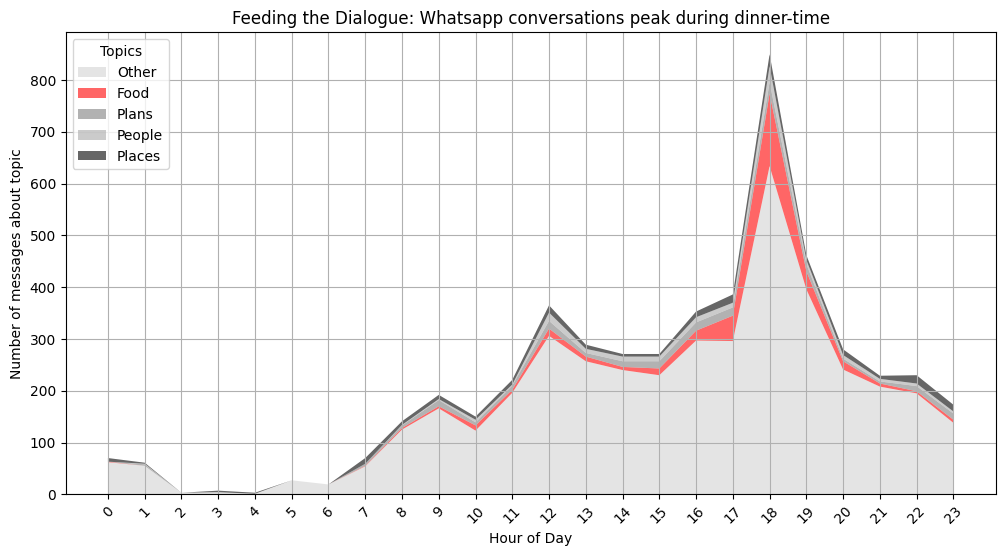

In [23]:
plt.figure(figsize=(12, 6))
# Define custom colors
colors = [  'lightgray', 'red',  'gray', 'darkgray', 'black' ]

plt.stackplot(df_counts.index, df_counts.T, colors=colors, labels=df_counts.columns, alpha=0.6)
plt.title("Feeding the Dialogue: Whatsapp conversations peak during dinner-time")
plt.xlabel('Hour of Day')
plt.ylabel('Number of messages about topic')
plt.xticks(df_counts.index, rotation=45)
# Add a legend with a title
plt.legend(loc='upper left', title='Topics')
plt.grid()
plt.show()

In [24]:
df_places[df_places['hour']<4]

,timestamp,message,author,has_emoji,language,date,isoweek,year-week,hour,topic,year,age,message_length,log_len,emoij_status
41,2021-09-13 00:10:00,Hoe laat ben je in Hilversum,nimble-wombat,False,NL,2021-09-13,37,2021-37,0,places,2021,50,28,3.332205,Without Emoji
64,2023-09-06 00:33:00,Ik blijf in Amsterdam slapen,effervescent-camel,False,NL,2023-09-06,36,2023-36,0,places,2023,21,28,3.332205,Without Emoji
541,2021-09-18 00:33:00,Zit nu in de trein naar Hilversum,effervescent-camel,False,NL,2021-09-18,37,2021-37,0,places,2021,19,33,3.496508,Without Emoji
546,2023-01-07 01:09:00,Nee ik heb nog met hen de trein,effervescent-camel,False,NL,2023-01-07,1,2023-01,1,places,2023,21,31,3.433987,Without Emoji
556,2023-10-22 00:16:00,Zit je al in de trein,nimble-wombat,False,NL,2023-10-22,42,2023-42,0,places,2023,52,21,3.044522,Without Emoji
633,2022-08-09 03:34:00,Check out my full story 'Mexico' at https://ww...,effervescent-camel,False,Non-verbaal,2022-08-09,32,2022-32,3,places,2022,20,145,4.976734,Without Emoji
634,2022-08-09 03:35:00,Dit is een app waar je mijn reis kan volgen!,effervescent-camel,False,NL,2022-08-09,32,2022-32,3,places,2022,20,44,3.784190,Without Emoji
651,2023-05-28 00:12:00,"Ja we hebben een hotel, zijn net binnen. Ziet ...",nimble-wombat,False,NL,2023-05-28,21,2023-21,0,places,2023,52,64,4.158883,Without Emoji
654,2023-05-31 01:10:00,Arrivati a Grado 👍🏻,nimble-wombat,True,IT,2023-05-31,22,2023-22,1,places,2023,52,19,2.944439,With Emoji
664,2023-07-28 00:00:00,Arrivati,nimble-wombat,False,NL,2023-07-28,30,2023-30,0,places,2023,52,8,2.079442,Without Emoji


In [25]:
whatsapp_topics = {
    'food': df_all[df_all['topic']=='food']['hour'].value_counts().sort_index(),
    'plans': df_all[df_all['topic']=='plans']['hour'].value_counts().sort_index(),
    'places': df_all[df_all['topic']=='places']['hour'].value_counts().sort_index(),
    'people': df_all[df_all['topic']=='people']['hour'].value_counts().sort_index(),
    'other': df_all[df_all['topic']=='other']['hour'].value_counts().sort_index(),
         }

<Figure size 1200x600 with 0 Axes>

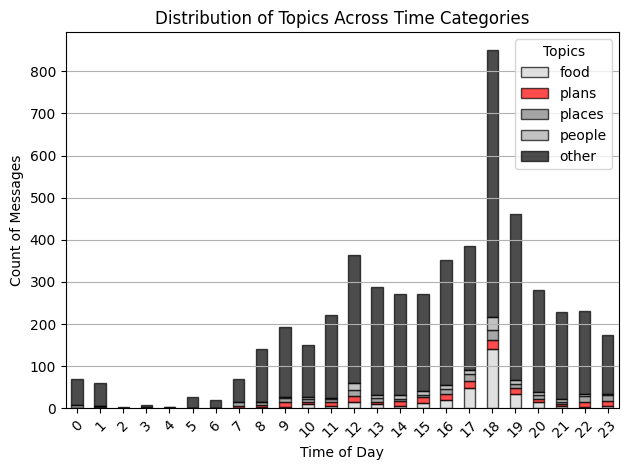

In [26]:
# Combine the data into a DataFrame
df2 = pd.DataFrame(whatsapp_topics)

# Plotting
plt.figure(figsize=(12, 6))

# Define colors
colors = ['lightgray', 'red', 'gray', 'darkgray', 'black']

# Create a stacked bar plot
df2.plot(kind='bar', stacked=True, color=colors, alpha=0.7, edgecolor='black')

# Title and labels
plt.title('Distribution of Topics Across Time Categories')
plt.xlabel('Time of Day')
plt.ylabel('Count of Messages')
plt.xticks(rotation=45)
plt.legend(title='Topics')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

In [27]:
#df_all[df_all['topic']=='places']['hour'].value_counts()

In [28]:
# Convert to DataFrames
hour_counts1 = pd.Series(whatsapp_topics['food'], name='Food')
hour_counts2 = pd.Series(whatsapp_topics['plans'], name='Plans')
hour_counts3 = pd.Series(whatsapp_topics['places'], name='Places')
hour_counts4 = pd.Series(whatsapp_topics['people'], name='People')
hour_counts5 = pd.Series(whatsapp_topics['other'], name='Other')

# Create a DataFrame and reindex to ensure all hours are included
df_counts = pd.DataFrame({
    'Places': hour_counts3,
    'Other': hour_counts5,
    'Food': hour_counts1,   
    'Plans': hour_counts2,  
    'People': hour_counts4,
    
    
    
})

#print(df_counts)  # Check the aligned DataFrame


In [29]:
# Step 1: Create the DataFrame from the provided data
data = {
    
    'Plans': df_counts['Plans'],
    'Food': df_counts['Food'],
    'People': df_counts['People'],
    'Places': df_counts['Places'],
    'Other': df_counts['Other'],
}

df_counts2 = pd.DataFrame(data).reindex(range(24), fill_value=0).fillna(0)
#df_counts2

<Figure size 2000x600 with 0 Axes>

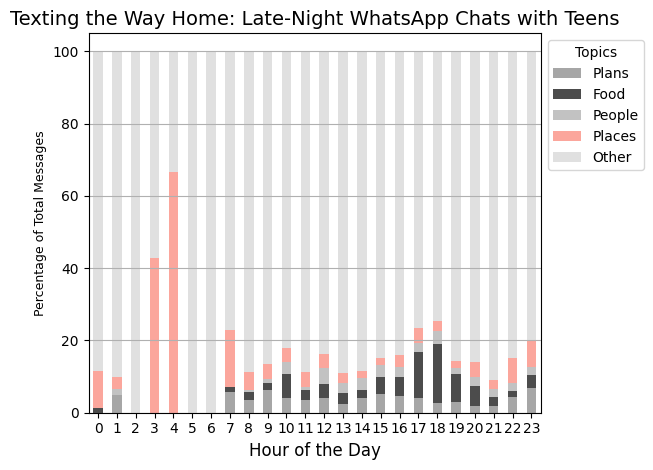

In [30]:
#df_counts2.drop(["Total"], inplace = True, axis=1)
df2 = pd.DataFrame(df_counts2)

# Create a DataFrame
df2.index = range(24)  # Setting hours as index

# Normalize the data
df_normalized2 = df2.div(df2.sum(axis=1), axis=0) * 100  # Convert to percentage

# Plot the normalized data
plt.figure(figsize=(20, 6))
df_normalized2.plot(kind='bar', stacked=True, color=['gray',  'black', 'darkgray','salmon',  'lightgray', ], alpha=0.7)

# Titles and labels
plt.title('Texting the Way Home: Late-Night WhatsApp Chats with Teens', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Percentage of Total Messages', fontsize=9)
plt.xticks(rotation=0)
plt.legend(title='Topics', fontsize=9)

# Set more y-ticks
#plt.gca().yaxis.set_major_locator(plt.MaxNLocator(20))  # Show up to 10 ticks on y-axis
#plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))  # Set a specific interval for y-ticks (e.g., every 10)
# Legend placed outside the plot
plt.legend(title='Topics', bbox_to_anchor=(1.00, 1), loc='upper left', fontsize=10)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

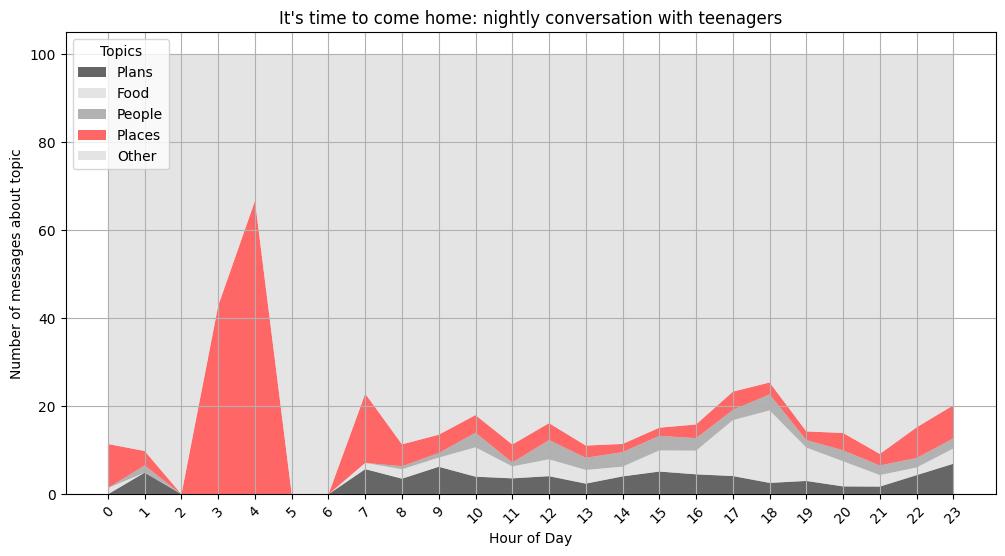

In [31]:
plt.figure(figsize=(12, 6))
# Define custom colors
colors = [ 'black', 'lightgray', 'gray',   'red', 'lightgray' ]

plt.stackplot(df_normalized2.index, df_normalized2.T, colors=colors, labels=df_normalized2.columns, alpha=0.6)
plt.title("It's time to come home: nightly conversation with teenagers")
plt.xlabel('Hour of Day')
plt.ylabel('Number of messages about topic')
plt.xticks(df_normalized2.index, rotation=45)
# Add a legend with a title
plt.legend(loc='upper left', title='Topics')
plt.grid()
plt.show()

In [32]:

# Step 1: Calculate total counts for each hour
df_counts2['Total'] = df_counts2.sum(axis=1)

# Step 2: Normalize each column (Food, Plans, People, Places, Other) to percentages
df_normalized = df_counts2.fillna(0).iloc[:, :-1].div(df_counts2['Total'], axis=0) * 100

# Display the normalized DataFrame
print(df_normalized)

         Plans       Food    People     Places       Other
hour                                                      
0     0.000000   1.428571  0.000000  10.000000   88.571429
1     4.918033   0.000000  1.639344   3.278689   90.163934
2     0.000000   0.000000  0.000000   0.000000  100.000000
3     0.000000   0.000000  0.000000  42.857143   57.142857
4     0.000000   0.000000  0.000000  66.666667   33.333333
5     0.000000   0.000000  0.000000   0.000000  100.000000
6     0.000000   0.000000  0.000000   0.000000  100.000000
7     5.714286   1.428571  0.000000  15.714286   77.142857
8     3.546099   2.127660  0.709220   4.964539   88.652482
9     6.250000   2.083333  1.041667   4.166667   86.458333
10    4.000000   6.666667  3.333333   4.000000   82.000000
11    3.619910   2.714932  0.904977   4.072398   88.687783
12    4.109589   3.835616  4.383562   3.835616   83.835616
13    2.422145   3.114187  2.768166   2.768166   88.927336
14    4.059041   2.214022  3.321033   1.845018   88.5608

<Figure size 1000x600 with 0 Axes>

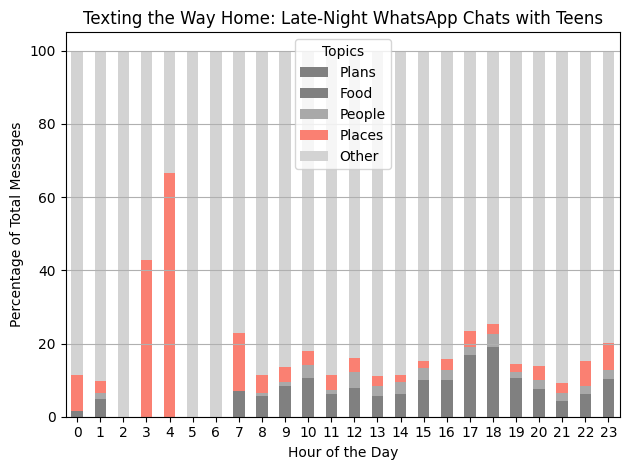

In [33]:
# Step 3: Plot the normalized data
plt.figure(figsize=(10, 6))
df_normalized.plot(kind='bar', stacked=True, color=['gray', 'gray', 'darkgray', 'salmon', 'lightgray'])
plt.title('Texting the Way Home: Late-Night WhatsApp Chats with Teens')
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Total Messages')
plt.xticks(rotation=0)
plt.legend(title='Topics')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

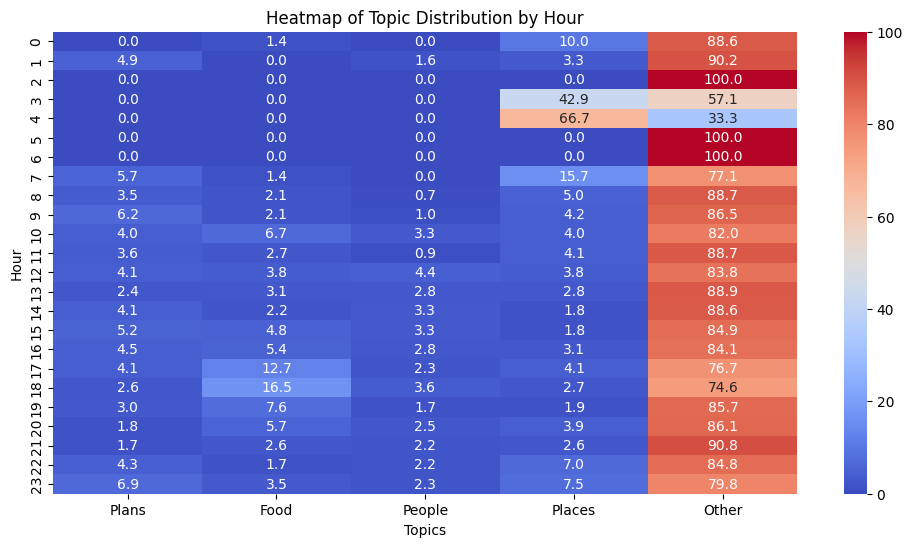

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df_normalized, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Heatmap of Topic Distribution by Hour')
plt.xlabel('Topics')
plt.ylabel('Hour')
plt.show()

<Figure size 1400x700 with 0 Axes>

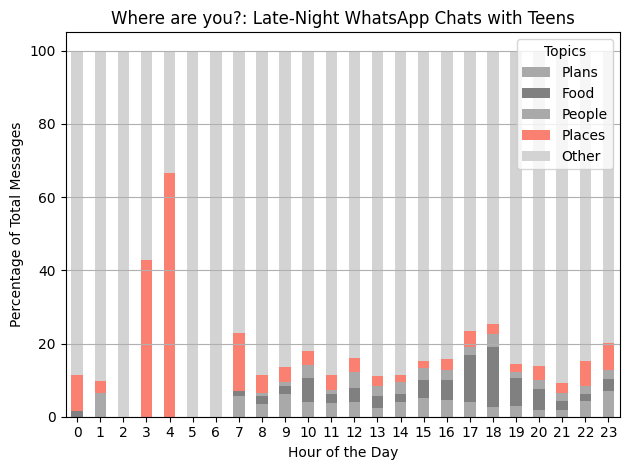

In [35]:
# Step 3: Plot the normalized data
plt.figure(figsize=(14, 7))

# Stacked bar plot
df_normalized.plot(kind='bar', stacked=True, color=['darkgray', 'gray', 'darkgray', 'salmon', 'lightgray'])

# Choose the specific category for the trend line (e.g., 'Food')
category = 'Places'
trend_values = df_normalized[category]

# Add the trend line for the selected category
#plt.plot(trend_values.index, trend_values, color='darkred', marker='o', label=f'{category} Trend', linewidth=1)

# Title and labels
plt.title('Where are you?: Late-Night WhatsApp Chats with Teens')
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Total Messages')
plt.xticks(rotation=0)
plt.legend(title='Topics', loc='upper right')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

In [36]:
# Step 1: Create the DataFrame from the provided data
data = {
    
    'Food': df_counts['Food'],
    'Plans': df_counts['Plans'],
    'People': df_counts['People'],
    'Places': df_counts['Places'],
    'Other': df_counts['Other'],
}

df_counts3 = pd.DataFrame(data).reindex(range(24), fill_value=0)
df_counts3.reset_index().fillna(0)

,hour,Food,Plans,People,Places,Other
0,0,1.0,0.0,0.0,7.0,62
1,1,0.0,3.0,1.0,2.0,55
2,2,0.0,0.0,0.0,0.0,3
3,3,0.0,0.0,0.0,3.0,4
4,4,0.0,0.0,0.0,2.0,1
5,5,0.0,0.0,0.0,0.0,27
6,6,0.0,0.0,0.0,0.0,19
7,7,1.0,4.0,0.0,11.0,54
8,8,3.0,5.0,1.0,7.0,125
9,9,4.0,12.0,2.0,8.0,166


In [37]:

# Step 2: Melt the DataFrame for seaborn compatibility
df_melted = df_counts3.reset_index().melt(id_vars='hour', var_name='Category', value_name='Count').fillna(0)
#df_melted = pd.melt(df_counts3, id_vars=['hour'], var_name='Category', value_name='Count')
df_melted['%'] = df_counts3.shape[0]/df_melted['Count']*100
df_melted['Total'] = df_melted.groupby('hour')['Count'].transform('sum').fillna(0)
df_melted['Percentage'] = (df_melted['Count'].fillna(0) / df_melted['Total'].fillna(0)) * 100

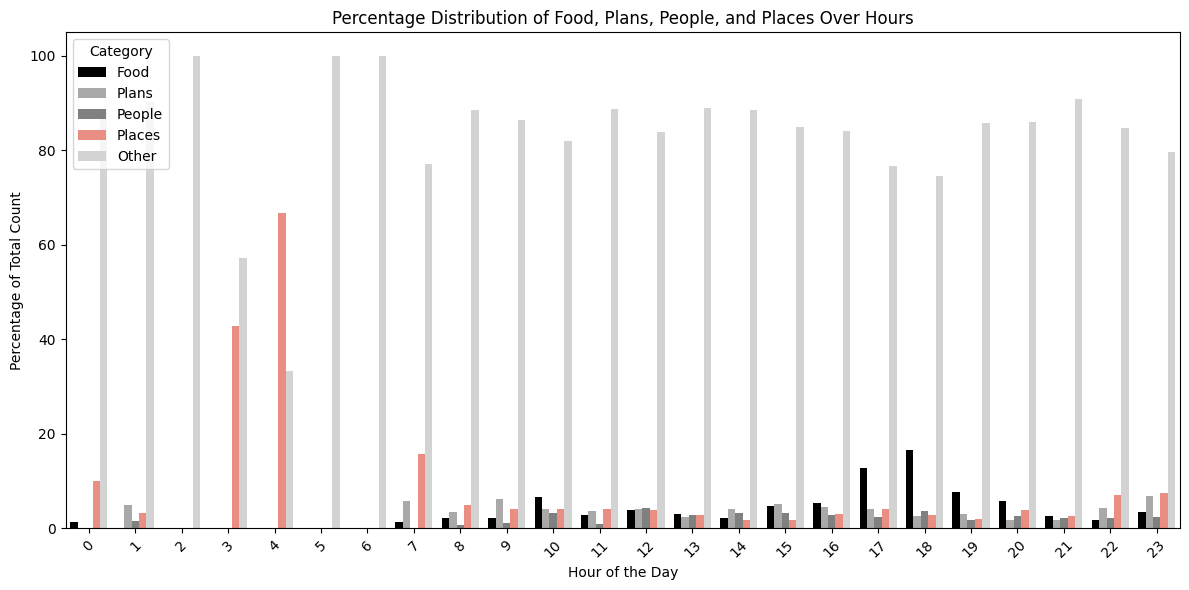

In [38]:

# Step 2: Melt the DataFrame
#df_melted = pd.melt(df_counts3, id_vars=['hour'], var_name='Category', value_name='Count')

# Step 3: Calculate total counts for each hour and normalize as a percentage


# Step 4: Plot the percentages
colors = [ 'black','darkgray', 'gray',   'salmon',  'lightgray']
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='hour', y='Percentage', hue='Category', palette=colors)
plt.title('Percentage Distribution of Food, Plans, People, and Places Over Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Total Count')
plt.legend(title='Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

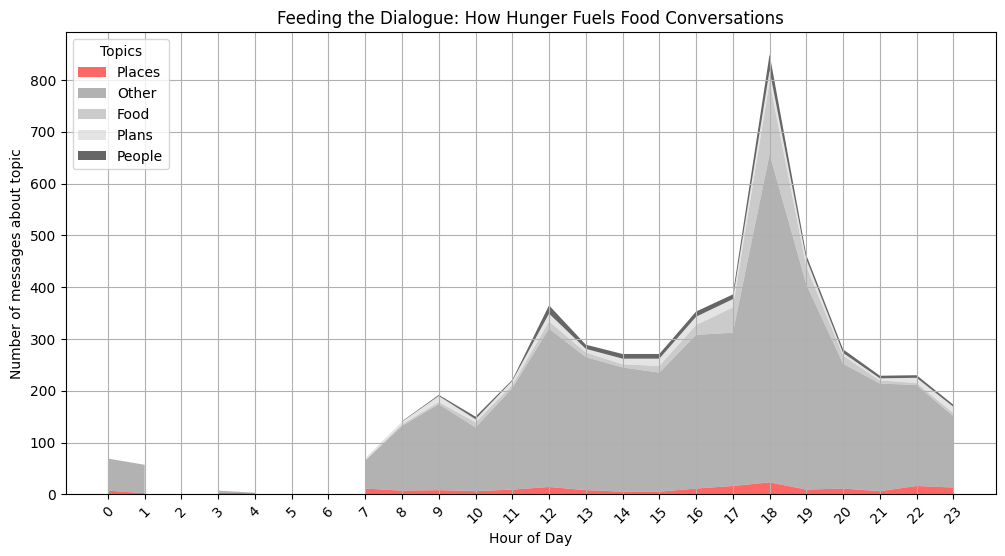

In [39]:
plt.figure(figsize=(12, 6))
# Define custom colors
colors = [  'red', 'gray', 'darkgray', 'lightgray', 'black' ]

plt.stackplot(df_counts.index, df_counts.T, colors=colors, labels=df_counts.columns, alpha=0.6)
plt.title("Feeding the Dialogue: How Hunger Fuels Food Conversations")
plt.xlabel('Hour of Day')
plt.ylabel('Number of messages about topic')
plt.xticks(df_counts.index, rotation=45)
# Add a legend with a title
plt.legend(loc='upper left', title='Topics')
plt.grid()
plt.show()

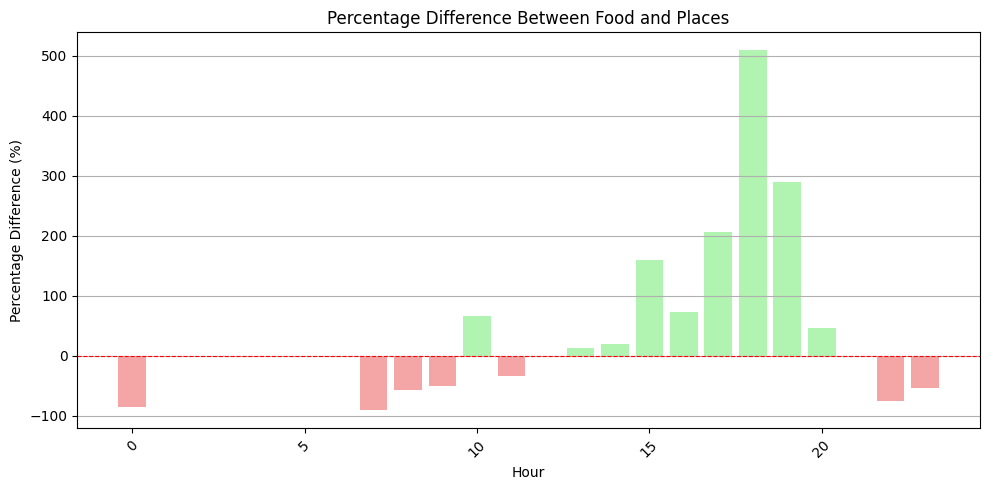

In [40]:
# Calculate percentage difference between Food and Plans
df_counts['Percentage Difference'] = ((df_counts['Food'] - df_counts['Places']) / df_counts['Places']) * 100

# Plot the percentage difference
plt.figure(figsize=(10, 5))
# Define colors based on percentage difference
colors = ['lightgreen' if x > 0 else 'lightcoral' if x < 0 else 'lightgray' for x in df_counts['Percentage Difference']]
plt.bar(df_counts.index, df_counts['Percentage Difference'], color=colors, alpha=0.7)
plt.title('Percentage Difference Between Food and Places')
plt.xlabel('Hour')
plt.ylabel('Percentage Difference (%)')
plt.axhline(0, color='red', linewidth=0.8, linestyle='--')  # Line at 0 for reference
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [41]:
# Step 1: Create the DataFrame from the provided data
data = {
    
    'Plans': df_counts['Plans'],
    'Food': df_counts['Food'],
    'People': df_counts['People'],
    'Places': df_counts['Places'],
    'Other': df_counts['Other'],
}

df_counts2 = pd.DataFrame(data).reindex(range(24), fill_value=0).fillna(0)

In [42]:
df_counts2.reset_index() 

,hour,Plans,Food,People,Places,Other
0,0,0.0,1.0,0.0,7.0,62
1,1,3.0,0.0,1.0,2.0,55
2,2,0.0,0.0,0.0,0.0,3
3,3,0.0,0.0,0.0,3.0,4
4,4,0.0,0.0,0.0,2.0,1
5,5,0.0,0.0,0.0,0.0,27
6,6,0.0,0.0,0.0,0.0,19
7,7,4.0,1.0,0.0,11.0,54
8,8,5.0,3.0,1.0,7.0,125
9,9,12.0,4.0,2.0,8.0,166


In [43]:

# Assuming df_counts2 is defined and contains your data
# Step 2: Melt the DataFrame
df_melted = pd.melt(df_counts2.reset_index() , id_vars=['hour'], var_name='Category', value_name='Count')

# Step 3: Calculate total counts for each hour and normalize as a percentage
df_melted['Total'] = df_melted.groupby('hour')['Count'].transform('sum')
df_melted['Percentage'] = df_melted['Count'] / df_melted['Total'] 

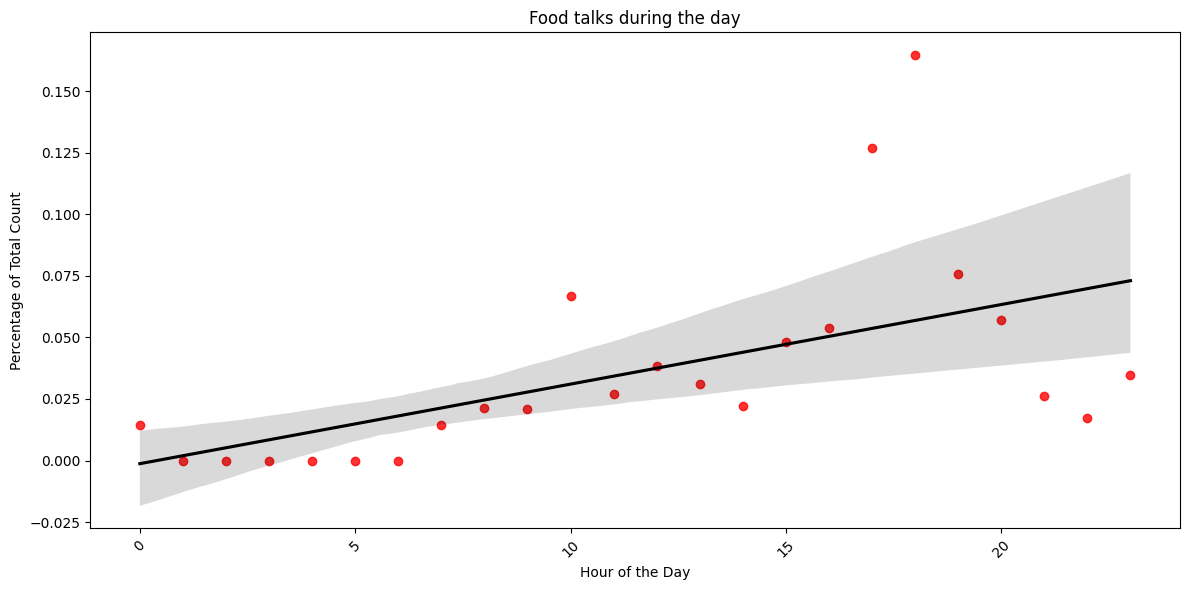

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Filter for a specific category, e.g., 'Food'
df_food = df_melted[df_melted['Category'] == 'Food']

# Step 4: Create a regplot for the 'Food' category
plt.figure(figsize=(12, 6))
sns.regplot(data=df_food, x='hour', y='Percentage', scatter_kws={'color': 'red'}, line_kws={'color': 'black'})
plt.title('Food talks during the day')
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Total Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
